In [4]:
## Jupyter notebook in python
## Produces plots allowing choice of analogue domain

## Caveat: 

In [5]:
import analogue_functions_C3S as my

import xarray as xr
#import os
#import subprocess
import numpy as np
import iris
#import calendar
import matplotlib.pyplot as plt
import matplotlib
cmaps = matplotlib.colormaps
#import sys
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.feature as cf
import calendar
#import netCDF4 as nc
#import glob
#from iris.util import equalise_attributes
#from iris.util import unify_time_units
#from scipy.stats import genextreme as gev
#from scipy.stats.stats import pearsonr
import scipy.stats as stats


In [6]:
# Defining the variables:

date = [2025, 'Apr', 5]  
impact_domain = [39, 34, -86, -93]# Impact region, [NORTH, SOUTH, WEST, EAST] 
Haz = 'tp' # Hazard variable, 't2m' or 'tp' 

In [7]:
### Automated variables - can be adjusted for sensitivity testing

# months to include, automatically three calendar month window around the event
month = date[1]
X = list(calendar.month_abbr)
i=X.index(month)
if 1<i<12:
    months = [X[i-1], X[i], X[i+1]]
elif i == 1:
    months = [X[12], X[i], X[i+1]]
elif i ==12:
    months = [X[i-1], X[i], X[1]]

# Or use this line to manually select different month set (can be full year)
#months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


R1 = [90, -90, 0, -180]  # Assess correlation globally
Y1 = 1950; Y2 = 2025 # Use years 1950-2025 (most available)

In [8]:
# Check which data source

# Initially using ERA5 daily data, if that gives no data switch to extended:
if my.reanalysis_data_single_date('t2m', date)==None:
    my.ERA5FILESUFFIX = "_daily_extended"
    print('ERA5 data not yet available, using ECMWF extended forecast for event data')
    event_data = 'extended'
    
# If extended also not available give error message:
if my.reanalysis_data_single_date('t2m', date)==None:
    print('Data is not available for that date, please select a date between 1 Jan 1950 and the present day')
    quit() ## If the date has not data (ERA5 or extended) then stop here, and print message above


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'Apr', 5]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'Apr', 5]


In [9]:
## This needs changing to allow the timeseries to be from a shapefile, or an already determined event definition timeseries from the probabilistic assessment
## t_ts needs to be a daily timeseries of the months defined earlier (default is 3-month window surrounding the event month) from 1950 to 2024
## Shorter timeframe could be used - Y1 and Y2 (furtehr up) would need altering to match

## Impact Index ts
t_data = my.reanalysis_data(Haz, Y1, Y2, date[1])
t_reg = my.extract_region(t_data, impact_domain)

coords = ('longitude', 'latitude')

if t_reg.coord('latitude').has_bounds():
    pass
else:
    t_reg.coord('latitude').guess_bounds()
if t_reg.coord('longitude').has_bounds():
    pass
else:
    t_reg.coord('longitude').guess_bounds()

weights=iris.analysis.cartography.area_weights(t_reg)

t_ts, _ = t_reg.collapsed(coords,iris.analysis.MEAN, weights=weights, returned=True)

/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [10]:
## Correlation Z500
z_data = my.reanalysis_data('z500', Y1, Y2, date[1])
z_data =  z_data - z_data.collapsed(['latitude', 'longitude'], iris.analysis.MEAN) # event for anavar to plot (fig a)
a, b, c = np.shape(z_data.data)
corr_field = np.empty((b,c))
p_field = np.empty((b,c))
for i in np.arange(b):
    print(i)
    for j in np.arange(c):
        x, y = stats.pearsonr(t_ts.data, z_data.data[:,i,j])
        corr_field[i,j] = x
        p_field[i,j] = y

## Correlation SLP
z_data = my.reanalysis_data('msl', Y1, Y2, date[1])
z_data =  z_data - z_data.collapsed(['latitude', 'longitude'], iris.analysis.MEAN) # event for anavar to plot (fig a)
a, b, c = np.shape(z_data.data)
corr_field2 = np.empty((b,c))
p_field2 = np.empty((b,c))
for i in np.arange(b):
    print(i)
    for j in np.arange(c):
        x, y = stats.pearsonr(t_ts.data, z_data.data[:,i,j])
        corr_field2[i,j] = x
        p_field2[i,j] = y

/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[Text(1, -1, '-1'), Text(1, 0, '0'), Text(1, 1, '1')]

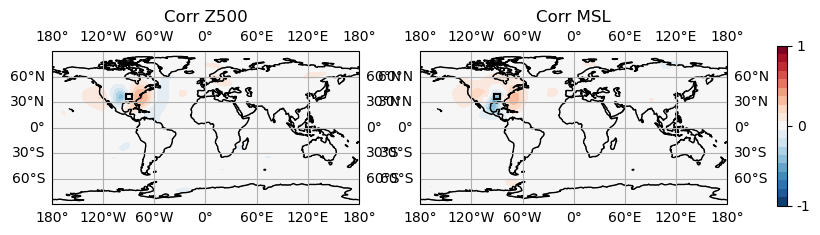

In [11]:
# Plot map of correlation
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,4))
lats=z_data.coord('latitude').points
lons=z_data.coord('longitude').points
con_lev = np.linspace(-1, 1, 20)

c1 = ax[0].contourf(lons, lats, corr_field, levels=con_lev, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax[0].add_feature(cf.COASTLINE)
ax[0].coastlines(linewidth=0.4)
ax[0].set_title('Corr Z500')
ax[0].gridlines(draw_labels=True)
my.plot_box(ax[0], impact_domain)
#plot_box(ax[0], [-45, -25, -65, -35])

c1 = ax[1].contourf(lons, lats, corr_field2, levels=con_lev, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax[1].add_feature(cf.COASTLINE)
ax[1].coastlines(linewidth=0.4)
ax[1].set_title('Corr MSL')
ax[1].gridlines(draw_labels=True)
my.plot_box(ax[1], impact_domain)
#plot_box(ax[1], [-40, -20, -70, -55])

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(c1, cax=cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['-1', '0', '1'])
#plt.tight_layout()

Before running the next cell you need to manually choose a domain, based on the maps plotted above. You can rerun the cell multiple time to move your domain until happy.
The domains found will then be needed in the rest of the analysis.

Choose two different domains: one for Z500 analogues and one for msl.
FORMAT [NORTH, SOUTH, WEST, EAST]

[Text(1, -1, '-1'), Text(1, 0, '0'), Text(1, 1, '1')]

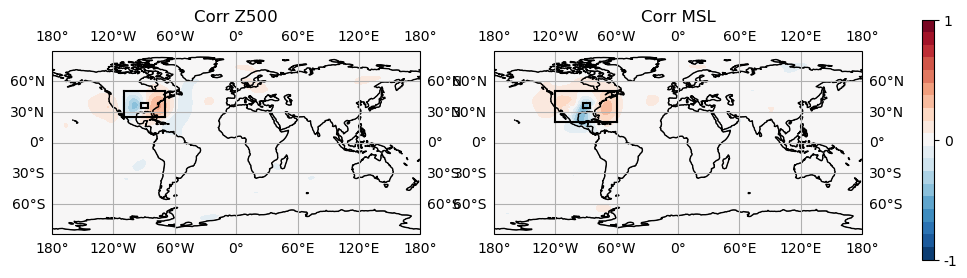

In [20]:
# Change the next two lines to a suitable domain
z500_domain = [50, 25, -70, -110]
slp_domain = [50, 20, -60, -120]

# Plot map of correlation
fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))
lats=z_data.coord('latitude').points
lons=z_data.coord('longitude').points
con_lev = np.linspace(-1, 1, 20)

c1 = ax[0].contourf(lons, lats, corr_field, levels=con_lev, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax[0].add_feature(cf.COASTLINE)
ax[0].coastlines(linewidth=0.4)
ax[0].set_title('Corr Z500')
ax[0].gridlines(draw_labels=True)
my.plot_box(ax[0], impact_domain)
my.plot_box(ax[0], z500_domain)

c1 = ax[1].contourf(lons, lats, corr_field2, levels=con_lev, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax[1].add_feature(cf.COASTLINE)
ax[1].coastlines(linewidth=0.4)
ax[1].set_title('Corr MSL')
ax[1].gridlines(draw_labels=True)
my.plot_box(ax[1], impact_domain)
my.plot_box(ax[1], slp_domain)

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
cbar = fig.colorbar(c1, cax=cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['-1', '0', '1'])
#plt.tight_layout()

In [21]:
## To ensure the domain adequately captures the sclae required for it to be the large-scale dynamics we are assessing, not local level patterns, this section checks the ratio of 'red' to 'blue'. 
# There may be cases where blue dominated the correlation (i.e. negative correlation, which would be expected for rainfall where low-pressure is likely to dominate high rainfall)
# Thus teh final line would need changing:
# print('SLP Blue: ',blue, ' Red: ', red, ' Ratio: ', red/(red+blue)) 
# Ratio required - around 25% (.2 to .3)

## This bit could be used to automate the region: find point of highest corr and then find box that gives 20:80 red:blue
X = z_data[0,:,:] 
X.data = corr_field
Y = my.extract_region(X, z500_domain)

a,b = np.shape(Y.data)
blue = 0
red = 0
for i in np.arange(a):
 for j in np.arange(b):
  if Y.data[i,j] < 0:
   blue +=1
  else:
   red +=1

print('Z500 Blue: ',blue, ' Red: ', red, ' Ratio: ', blue/(red+blue)) # want val ~.2

X = z_data[0,:,:] 
X.data = corr_field2
Y = my.extract_region(X, slp_domain)

a,b = np.shape(Y.data)
blue = 0
red = 0
for i in np.arange(a):
 for j in np.arange(b):
  if Y.data[i,j] < 0:
   blue +=1
  else:
   red +=1

print('SLP Blue: ',blue, ' Red: ', red, ' Ratio: ', blue/(red+blue)) # want val .2-.3

Z500 Blue:  1998  Red:  2002  Ratio:  0.4995
SLP Blue:  2598  Red:  4602  Ratio:  0.36083333333333334


In [22]:
# Summary print out
print('Summary: identify analogues domain')
print('Event definition:')
print('     Date: ', date)
print('     Hazard: ', Haz)
print('     Impact domain: ', impact_domain)
print('     Months assessed: ', months)
print('RESULT:')
print('    Z500 domain:', z500_domain)
print('    MSL domain:', slp_domain)



Summary: identify analogues domain
Event definition:
     Date:  [2025, 'Apr', 5]
     Hazard:  tp
     Impact domain:  [39, 34, -86, -93]
     Months assessed:  ['Mar', 'Apr', 'May']
RESULT:
    Z500 domain: [50, 25, -70, -110]
    MSL domain: [50, 20, -60, -120]
